# Kimberlite TFA Inversion

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA) data on a regular grid of a synthetic kimberlitic model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os

from fatiando import utils
from fatiando.gravmag import polyprism
from fatiando.mesher import PolygonalPrism
from fatiando.vis import mpl, myv
from matplotlib import colors, ticker, cm
from IPython.display import Image as img
from matplotlib.mlab import normpdf

C:\Users\bes064\AppData\Local\Continuum\anaconda2\lib\site-packages\fatiando\vis\mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")
C:\Users\bes064\AppData\Local\Continuum\anaconda2\lib\site-packages\fatiando\vis\myv.py:51: UserWarning: This module will be removed in v0.7.
  warnings.warn("This module will be removed in v0.7.")


### Auxiliary functions

In [2]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing model parameters

In [3]:
with open('kimberlite_data/kimberlite_model.pickle') as w:
        kimberlite_model = pickle.load(w)

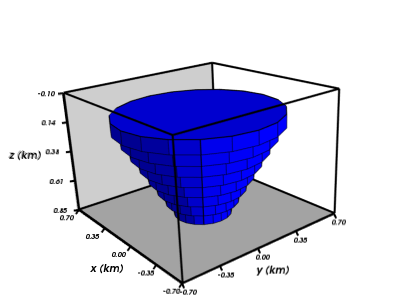

In [4]:
img(filename='kimberlite_data/kimberlite_true.png')

### Observation points and observed data

In [5]:
with open('../grids/regular_grid.pickle') as w:
        regular_grid = pickle.load(w)

In [6]:
with open('kimberlite_data/kimberlite_data.pickle') as w:
        kimberlite_data = pickle.load(w)

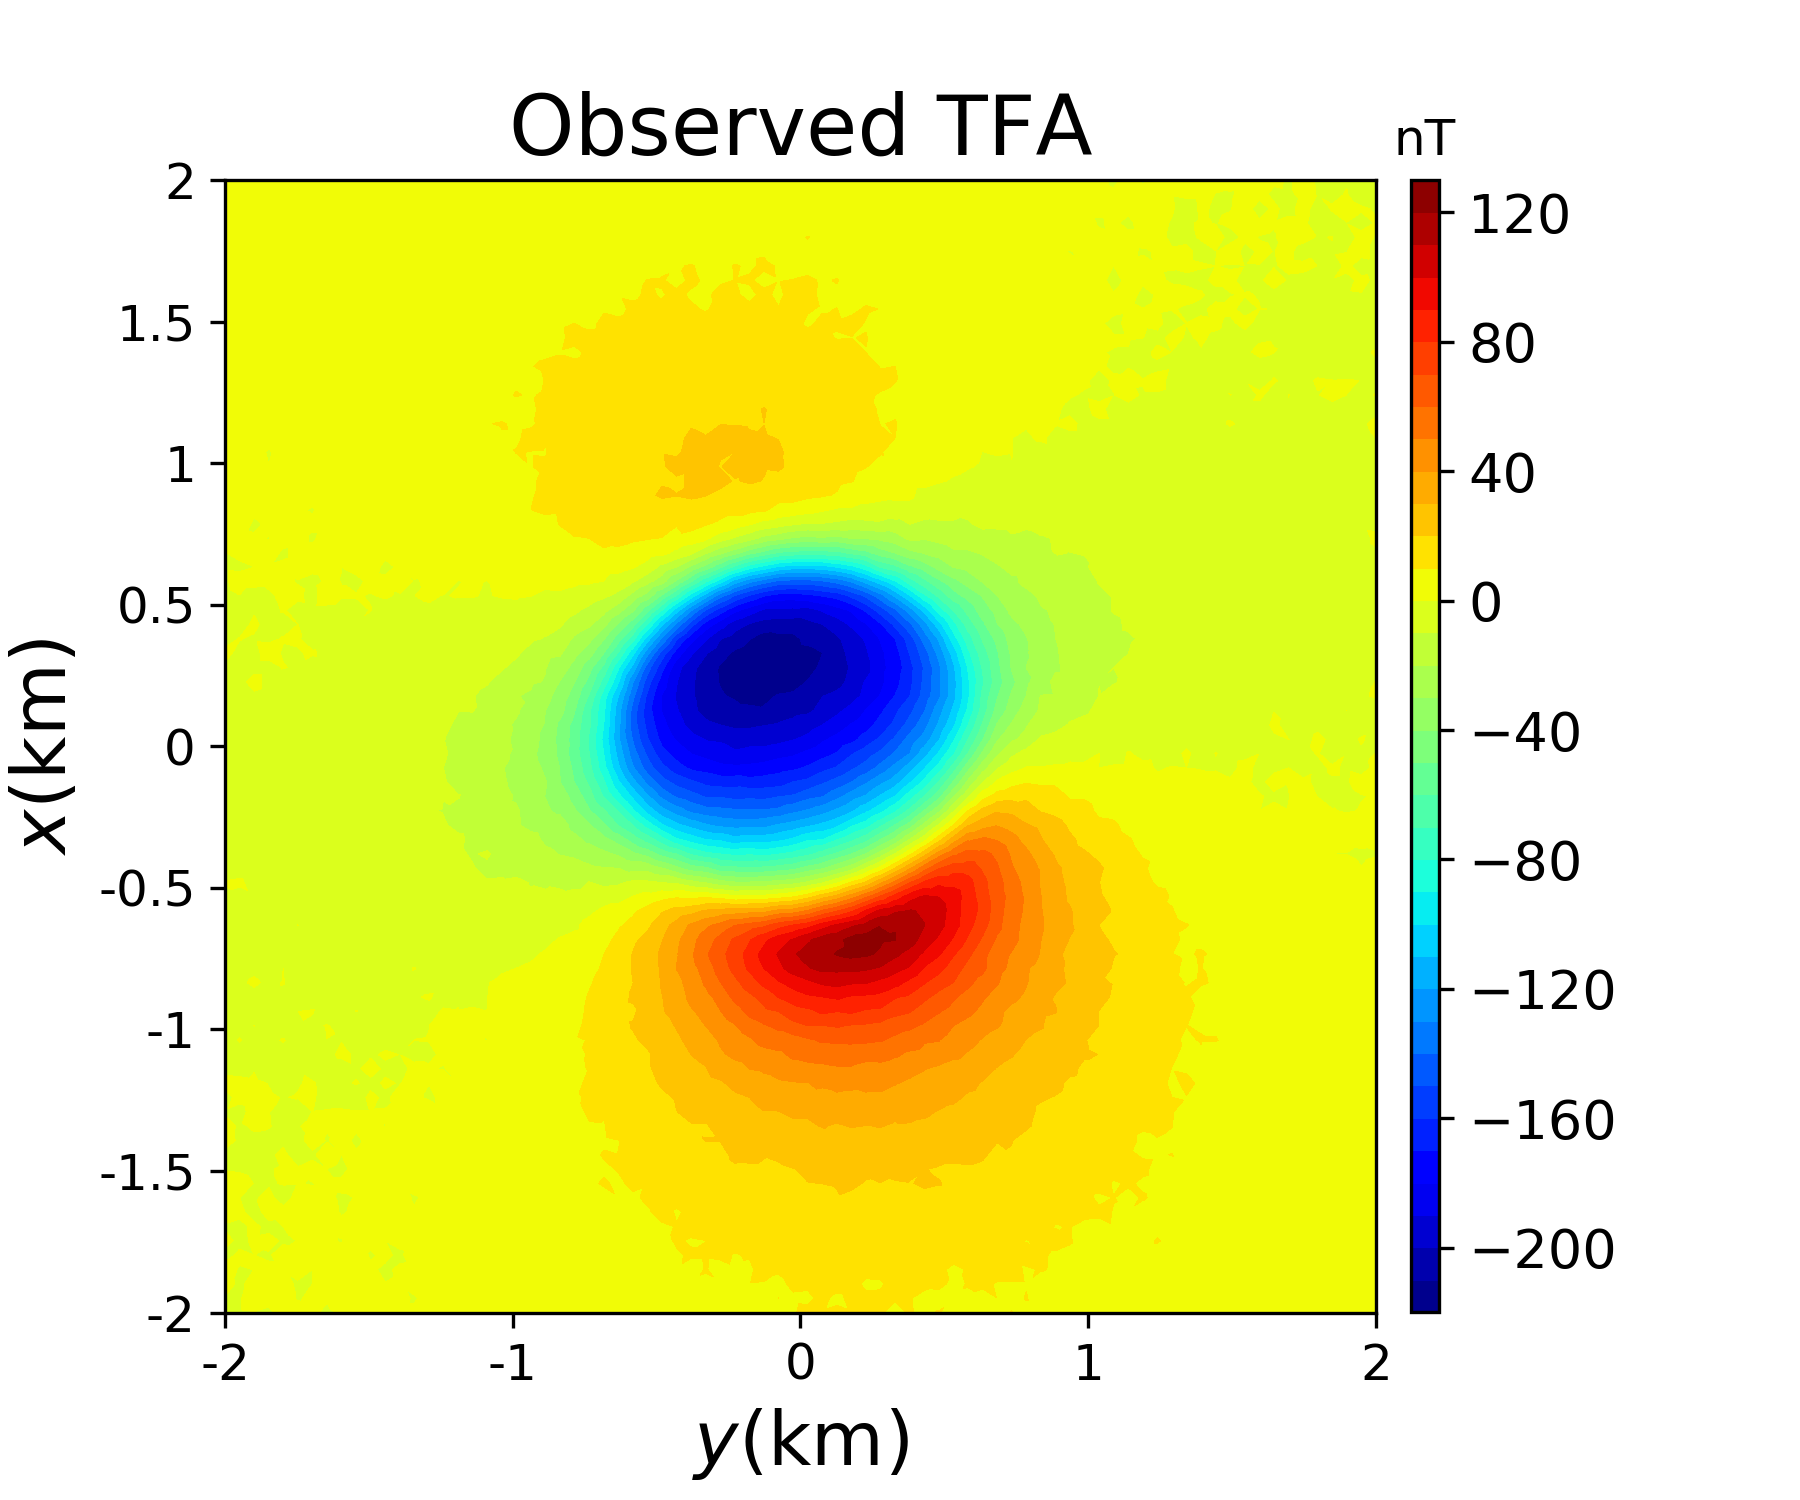

In [7]:
img(filename='kimberlite_data/obs_tfa.png', width=400, height=400)

In [8]:
# observed data and observation points
dobs = kimberlite_data['tfa_obs']
xp = regular_grid['xp']
yp = regular_grid['yp']
zp = regular_grid['zp']
N = regular_grid['N']

### Parameters of the initial model

In [9]:
M = 15 # number of vertices per prism
L = 5 # number of prisms
P = L*(M+2) + 1 # number of parameters

# magnetization direction
incs = kimberlite_model['inc']
decs = kimberlite_model['dec']

# depth to the top, thickness and radius
z0 = kimberlite_model['z0']
dz = 250.
r = 800.

# total magnetization
props = {'magnetization': utils.ang2vec(
        kimberlite_model['intensity'], incs, decs)}
rin = np.zeros(M) + r
m0 = np.hstack((rin, np.zeros(2)))
m0 = np.resize(m0, P - 1) 
m0 = np.hstack((m0, dz)) # inicial parameters vector
model0 = mfun.param2polyprism(m0, M, L, z0, props) # list of classes of prisms

# main field
inc, dec = kimberlite_data['main_field']

# predict data
d0 = polyprism.tf(xp, yp, zp, model0, inc, dec)

### Limits

In [10]:
# limits for parameters in meters
rmin = 10.
rmax = 1300.
x0min = -1300.
x0max = 1300.
y0min = -1300.
y0max = 1300.
dzmin = 10.
dzmax = 300.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [11]:
# variation for derivatives
deltax = 0.01*np.max(x0max)
deltay = 0.01*np.max(y0max)
deltar = 0.01*np.max(rmax)
deltaz = 0.01*np.max(dzmax)

### Outcropping parameters

In [12]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = kimberlite_model['param_vec'][:M+2]

### Folder to save the results

In [13]:
if incs == kimberlite_model['inc'] and decs == kimberlite_model['dec']:
    mypath = 'tfa_inversion/true_direction/r%d_int%d_z0%d_dz%d' % (rin[0], np.linalg.norm(props['magnetization']), z0, dz)
    if not os.path.isdir(mypath):
       os.makedirs(mypath)
else:
    mypath = 'tfa_inversion/wrong_direction/inc%d_dec%d_r%d_int%d_z0%d_dz%d' % (incs, decs, rin[0], np.linalg.norm(props['magnetization']), z0, dz)
    if not os.path.isdir(mypath):
       os.makedirs(mypath)

In [14]:
# output of inversion
kimberlite_inversion = dict()

### Regularization parameters

In [15]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 1000.
dlamb = 10.      # step for Marquadt's parameter

a1 = 0.0001  # adjacent radial distances within each prism
a2 = 0.0001   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 0.0001     # vertically adjacent origins
a6 = 0.00008   # zero order Tikhonov on adjacent radial distances
a7 = 0.000001     # zero order Tikhonov on thickness of each prism

In [16]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [17]:
itmax = 30
itmax_marq = 10
tol = 1.0e-5     # stop criterion

In [18]:
kimberlite_inversion['x'] = xp
kimberlite_inversion['y'] = yp
kimberlite_inversion['z'] = zp
kimberlite_inversion['observed_data'] = dobs

In [19]:
kimberlite_inversion['inc_dec'] = [incs, decs]
kimberlite_inversion['z0'] = z0
kimberlite_inversion['initial_dz'] = dz
kimberlite_inversion['intial_r'] = r
kimberlite_inversion['initial_estimate'] = model0
kimberlite_inversion['initial_data'] = d0
kimberlite_inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
kimberlite_inversion['tol'] = tol
kimberlite_inversion['main_field'] = [kimberlite_data['main_field'][0], kimberlite_data['main_field'][1]]

### Inversion

In [20]:
d_fit, m_est, model_est, phi_list = mfun.levmarq_tf(
    xp, yp, zp, m0, M, L, delta,
    itmax, itmax_marq, lamb,
    dlamb, tol, mmin, mmax,
    m_out, dobs, inc, dec,
    props, alpha, z0, dz
)

it:  0   it_marq:  0   lambda: 1e+03   misfit: 2.90875e+03
it:  1   it_marq:  0   lambda: 1e+02   misfit: 2.28879e+03
it:  2   it_marq:  0   lambda: 1e+01   misfit: 9.77926e+02
it:  3   it_marq:  0   lambda: 1e+00   misfit: 2.20761e+02
it:  4   it_marq:  0   lambda: 1e-01   misfit: 1.35313e+03
it:  4   it_marq:  1   lambda: 1e+00   misfit: 1.09166e+03
it:  4   it_marq:  2   lambda: 1e+01   misfit: 1.29141e+02
it:  5   it_marq:  0   lambda: 1e+00   misfit: 3.27771e+02
it:  5   it_marq:  1   lambda: 1e+01   misfit: 8.66482e+01
it:  6   it_marq:  0   lambda: 1e+00   misfit: 8.14431e+02
it:  6   it_marq:  1   lambda: 1e+01   misfit: 5.77674e+01
it:  7   it_marq:  0   lambda: 1e+00   misfit: 3.12986e+01
it:  8   it_marq:  0   lambda: 1e-01   misfit: 1.01368e+03
it:  8   it_marq:  1   lambda: 1e+00   misfit: 9.36671e+02
it:  8   it_marq:  2   lambda: 1e+01   misfit: 8.77199e+02
it:  8   it_marq:  3   lambda: 1e+02   misfit: 8.09509e+02
it:  8   it_marq:  4   lambda: 1e+03   misfit: 1.23805e+

# Results

In [21]:
kimberlite_inversion['data_fit'] = d_fit
kimberlite_inversion['estimate'] = m_est
kimberlite_inversion['prisms'] = model_est
kimberlite_inversion['objective'] = phi_list
kimberlite_inversion['residual'] = dobs - d_fit

In [24]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(kimberlite_inversion, f)